<a href="https://colab.research.google.com/github/0zeynep/mobil_cihaz_fiyat_tahmini/blob/main/machine_learning_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mobil Cihaz Fiyat Tahmini: RAM'in Etkisinin Analizi**

**Projenin Amacı**

Bu projenin temel amacı, mobil cihaz fiyatlarını (Launched Price (USA)) etkileyen en önemli donanım özelliklerinden biri olan RAM ile ABD Lansman Fiyatı arasındaki ilişkiyi incelemek ve bu ilişkiye dayanarak bir Doğrusal Regresyon (Linear Regression) modeli oluşturmaktır.



**1.Kullanılan Dataset**


**Telefonlara ait:**


Marka


Model


RAM


Ağırlık


Kamera çözünürlükleri


Ekran boyutu


Batarya kapasitesi


Farklı ülkelere göre fiyatlar


Çıkış yılı


gibi özellikleri içermektedir.


**Ortalama Hata ve Başarı**

RMSE (Ortalama Hata): 388.94

R2 Skoru (Başarı): 0.18

Başarının düşük olmasının nedeni sadece RAM ile fiyat athiümini yapmaya çalışmaktır.Diğer özellikler eklenirse daha başarılı bir sonuç elde edilebilir.

**Sırasıyla adımlar şu şekildedir :**

**1)Dataset'i Yükleme**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mobiles=pd.read_csv("mobiles_dataset.csv",encoding='latin-1')
mobiles.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 224,999","INR 79,999","CNY 5,799",USD 799,"AED 2,799",2024
1,Apple,iPhone 16 256GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 234,999","INR 84,999","CNY 6,099",USD 849,"AED 2,999",2024
2,Apple,iPhone 16 512GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 244,999","INR 89,999","CNY 6,499",USD 899,"AED 3,199",2024
3,Apple,iPhone 16 Plus 128GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 249,999","INR 89,999","CNY 6,199",USD 899,"AED 3,199",2024
4,Apple,iPhone 16 Plus 256GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 259,999","INR 94,999","CNY 6,499",USD 949,"AED 3,399",2024


**2)Fiyat Temizleme**


Fiyatlardaki USD,PKR gib sayısal olmayan ifadeler temizlenir.

In [ ]:
import re
def clean_price_fixed_FINAL(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    x = re.sub(r"[A-Za-z\s]+", "", x)
    x = x.replace(",", "")
    if not x or x == '-':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan
price_columns = [col for col in mobiles.columns if "Price" in col]
for col in price_columns:
    mobiles[col] = mobiles[col].apply(clean_price_fixed_FINAL)
threshold=5000
mobiles = mobiles[mobiles['Launched Price (USA)'] < threshold].copy()


**3)RAM ve Front Camera Temizleme**

RAM'deki GB ifadesi çıkarılır.Front Cameradaki MB ifadesi çıkarılır.

In [ ]:
mobiles["RAM"]=mobiles["RAM"].astype(str).str.extract(r'(\d+\.?\d*)',expand=False)
mobiles["RAM"]=pd.to_numeric(mobiles["RAM"],errors="coerce")
mobiles["Front Camera"] = mobiles["Front Camera"].astype(str).str.extract(r"(\d+\.?\d*)", expand=False)
mobiles["Front Camera"] = pd.to_numeric(mobiles["Front Camera"],errors='coerce')

**4)Hedef Belirleme**

RAM'e göre değişen Launched Price(USD) değeri tahmin edilmek istenmiştir.

In [ ]:
target="Launched Price (USA)"
y=mobiles[target]
features=["RAM","Launched Year","Front Camera"]
X_raw=mobiles[features]


In [ ]:
combined_mobiles = pd.concat([X_raw, y], axis=1).dropna()
X=combined_mobiles[features]
y=combined_mobiles[target]



**5)Korelasyon Matrisi**

RAM ile Launched Price (USA) arasındaki katsayı, diğerlerinden en yüksek ve +1'e en yakın olanıdır. Bu, RAM'in fiyattaki değişimi açıklamada en güçlü değişken olduğunu gösterir.

In [ ]:
correlation_data = mobiles[features + [target]].copy()
correlation_data = correlation_data.dropna()
correlation_matrix = correlation_data.corr()
print("--- Korelasyon Matrisi ---")
print(correlation_matrix)

--- Korelasyon Matrisi ---
                           RAM  Launched Year  Front Camera  \
RAM                   1.000000       0.380441      0.459534   
Launched Year         0.380441       1.000000      0.166024   
Front Camera          0.459534       0.166024      1.000000   
Launched Price (USA)  0.466653       0.053451      0.072105   

                      Launched Price (USA)  
RAM                               0.466653  
Launched Year                     0.053451  
Front Camera                      0.072105  
Launched Price (USA)              1.000000  


**6)RAM miktarı ile telefonların ortalama lansman fiyatı arasındaki ilişkiyi gösteren  bar grafiği**

<Axes: xlabel='RAM'>

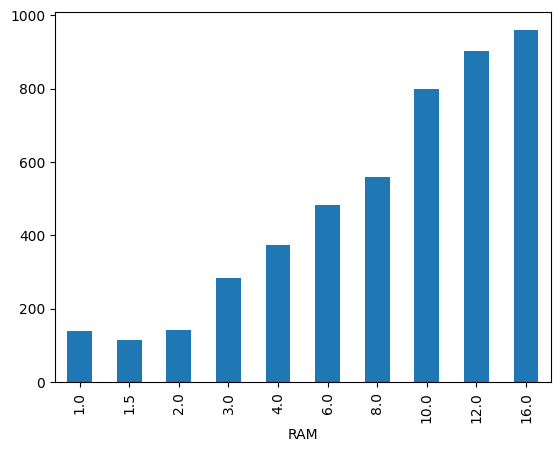

In [ ]:
mobiles.groupby("RAM")["Launched Price (USA)"].mean().plot(kind="bar")

**7)Linear regresyon modeli oluşturma**

Hedef ve özellik tanımlanır.

Veri şekli düzenlenir.

Veri seti X_train %80 ve y_train %20 olmak üzere rastgele bölünür.

Model eğitimi ve tahmini yapılır.


RMSE (Ortalama Hata): 388.94
R2 Skoru (Başarı): 0.18


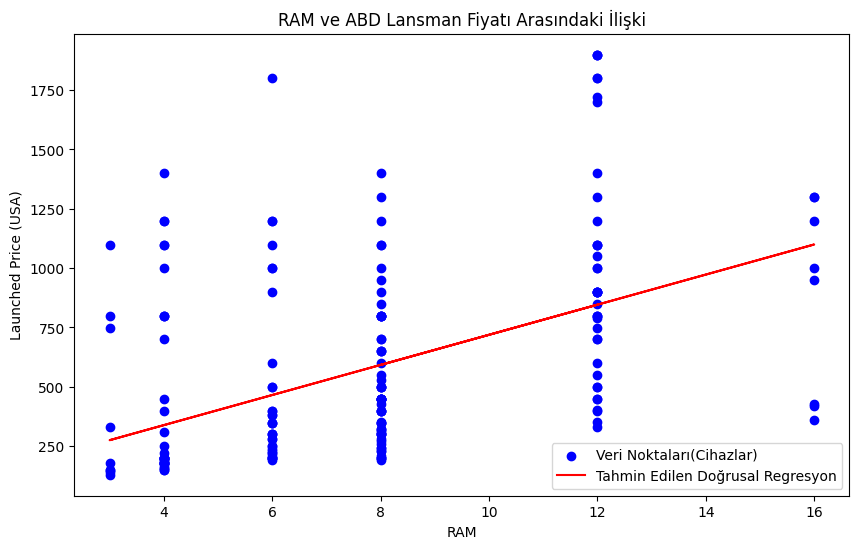

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
target = "Launched Price (USA)"
feature = "RAM"
ram_price_df = mobiles[[feature, target]].copy()
clean_subset = ram_price_df.dropna()
X = clean_subset[feature].to_numpy().reshape(-1, 1)
y = clean_subset[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_score_test = lin_reg.score(X_test, y_test)


plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Veri Noktaları(Cihazlar)')
plt.plot(X_test, y_pred, color='red', label='Tahmin Edilen Doğrusal Regresyon')
plt.title('RAM ve ABD Lansman Fiyatı Arasındaki İlişki')
plt.xlabel('RAM')
plt.ylabel('Launched Price (USA)')
plt.legend()
plt.show()


**8)Neden Linear Regresyon seçildi?**


Kolay yorumlanabilirdir.

Basit ve hızlıdır.

Fiyat tahmini için uygundur .

Dataset ile uyumludur.

**Diğer Regresyon Modelleri Neden Seçilmedi**

**Polinomical Regression:**

Veri setinde bariz bir polinomik ilişki gözlenmemiştir.

Yorumlanabilirliği düşüktür.

**Random Forest:**

Çok karmaşık olacağı için seçilmemiştir.

Linear modele göre daha yavaştır.

**SVR**

Karmaşıktır.Aykırı değerler için dirençlidir.Bu veri seti için gerekli değildir.

Yorumlaması zor.











**9)Sonuç**

Bu proje kapsamında yapılan analizler ve oluşturulan Lineer Regresyon modeli, mobil cihaz fiyatlarını etkileyen RAM özelliğinin rolünü açıkça göstermiştir.

**Güçlü Eğilim**: RAM miktarı ile ABD Lansman Fiyatı arasında net bir pozitif ilişki olduğu gözlemlenmiştir. Bar grafiği, RAM arttıkça ortalama fiyatın istikrarlı bir şekilde arttığını kanıtlamaktadır.

**Model Seçimi**: Korelasyon matrisi, RAM'in diğer incelenen özellikler (Launched Year, Front Camera) arasında Fiyat ile en belirgin ilişkiye sahip değişken olduğunu göstermiştir.





